In [ ]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio
!pip install fsspec==2024.6.1
!pip install datasets==3.0.0
!pip install gcsfs==2024.6.0
!pip install jiwer
!pip install evaluate

# Imports
from google.colab import drive
import os, sys, itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
from torch.utils.data import Dataset

from datasets import load_dataset
import transformers
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import VisionEncoderDecoderModel, TrOCRProcessor, default_data_collator
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.6.1 which is incompatible.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
  Attempting uninstall: gcsfs
    F

In [ ]:
# Environment info
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.10.1
        Pandas: 2.2.2
  Transformers: 4.46.3
         Torch: 2.5.1+cu121


In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/CMPE 252 Project/whiteplate_normal/'

Mounted at /content/drive


In [ ]:
# Dataset Preparation
file_names, texts = [], []
for file in os.listdir(path):
    if file.endswith(('.jpg', '.png')):
        file_names.append(file)
        texts.append(os.path.splitext(file)[0])

dataset = pd.DataFrame({'file_name': file_names, 'text': texts})
train_dataset, test_dataset = train_test_split(dataset, train_size=0.80, random_state=42)
train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

In [ ]:
class License_Plates_OCR_Dataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        return {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `testingLicensePlate` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is:

In [ ]:
# Model Initialization
MODEL_CKPT = "microsoft/trocr-base-printed"
processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)
train_ds = License_Plates_OCR_Dataset(path, train_dataset, processor)
test_ds = License_Plates_OCR_Dataset(path, test_dataset, processor)

model = VisionEncoderDecoderModel.from_pretrained(MODEL_CKPT)
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Metrics
cer_metric = evaluate.load("cer")

# Adversarial Patch Attack to Maximize CER
def overlay_patch(image_tensor, patch):
    """Overlay patch on center of the image."""
    patched_image = image_tensor.clone()
    patch_height, patch_width = patch.shape[1:]
    center_y = (patched_image.shape[1] - patch_height) // 2
    center_x = (patched_image.shape[2] - patch_width) // 2
    patched_image[:, center_y:center_y + patch_height, center_x:center_x + patch_width] = patch
    return patched_image

def fast_gradient_sign_patch(image_tensor, true_label, processor, model, cer_metric, patch_size=(100, 100),
                             epochs=10, lr=0.01):
    """
    Generate an adversarial patch to fool the OCR model, ensuring device consistency.
    """
    # Ensure all computations happen on the same device
    device = model.device
    image_tensor = image_tensor.to(device)
    patch = torch.rand((3, *patch_size), device=device, requires_grad=True)
    optimizer = torch.optim.Adam([patch], lr=lr)

    # Tokenize the true label and move it to the same device
    true_ids = processor.tokenizer(true_label, return_tensors="pt").input_ids.to(device)

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Overlay the patch on the image
        patched_image = overlay_patch(image_tensor, patch)

        # Forward pass through the model
        outputs = model(patched_image.unsqueeze(0), labels=true_ids)

        # Use cross-entropy loss
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Clamp patch values to ensure valid pixel range
        patch.data = torch.clamp(patch.data, 0, 1)

        # Compute CER (for logging purposes)
        predictions = processor.batch_decode(outputs.logits.argmax(dim=-1), skip_special_tokens=True)
        cer = cer_metric.compute(predictions=predictions, references=[true_label])

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, CER: {cer:.4f}")

    return patch



In [ ]:
# Evaluate on Test Image
true_label = test_dataset.iloc[0]['text']
image_path = path + test_dataset.iloc[0]['file_name']

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move processor-preprocessed tensor to the same device
image_tensor = processor(image, return_tensors="pt").pixel_values[0].to(device)

# Ensure the model is on the same device
model = model.to(device)

# Generate Adversarial Patch
adversarial_patch = fast_gradient_sign_patch(
    image_tensor, true_label, processor, model, cer_metric,
    patch_size=(100, 100), epochs=10, lr=0.01
)

# Apply the adversarial patch to the image
patched_image = overlay_patch(image_tensor, adversarial_patch)

# Ensure patched_image is on the correct device and has batch dimension
patched_image = patched_image.unsqueeze(0).to(device)

# Evaluate the model on the patched image
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    outputs = model.generate(patched_image)  # Use generate for inference

# Decode predictions and compute CER
patched_predictions = processor.batch_decode(outputs, skip_special_tokens=True)
patched_cer = cer_metric.compute(predictions=patched_predictions, references=[true_label])

# Print results
print(f"True Label: {true_label}")
print(f"Predicted Label (Patched): {patched_predictions}")
print(f"CER on Patched Image: {patched_cer:.4f}")



Epoch 1/10, Loss: 6.1174, CER: 0.8571
Epoch 2/10, Loss: 5.8741, CER: 0.8571
Epoch 3/10, Loss: 5.7155, CER: 0.7143
Epoch 4/10, Loss: 5.6127, CER: 0.7143
Epoch 5/10, Loss: 5.5154, CER: 0.7143
Epoch 6/10, Loss: 5.4110, CER: 0.5714
Epoch 7/10, Loss: 5.3069, CER: 0.5714
Epoch 8/10, Loss: 5.2190, CER: 0.5714
Epoch 9/10, Loss: 5.1339, CER: 0.5714
Epoch 10/10, Loss: 5.0390, CER: 0.4286


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1493: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


True Label: PZ68KRY
Predicted Label (Patched): ['@8 PZCSKRY']
CER on Patched Image: 0.7143


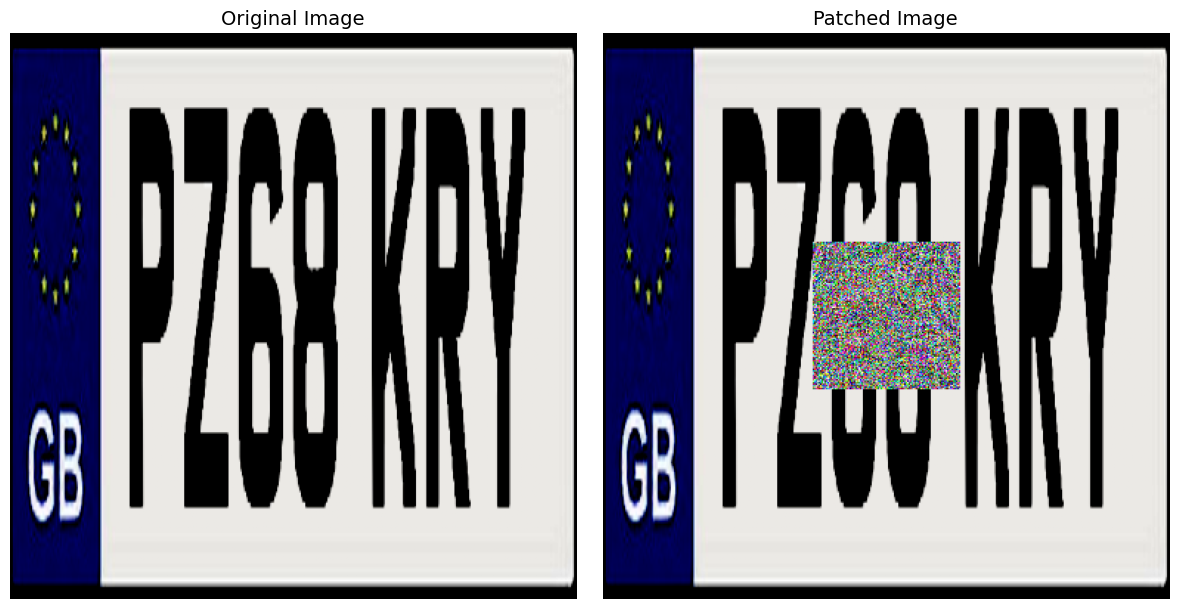

In [ ]:
import matplotlib.pyplot as plt

def show_original_and_patched(original_image_tensor, patched_image_tensor, title1="Original Image", title2="Patched Image"):
    """
    Displaying the original and patched images side by side
    """
    #Remove batch dimension if it exists
    if len(patched_image_tensor.shape) == 4:  # Shape [1, C, H, W]
        patched_image_tensor = patched_image_tensor.squeeze(0)
    #Tensors to NumPy arrays
    original_image_np = original_image_tensor.permute(1, 2, 0).cpu().detach().numpy().clip(0, 1)
    patched_image_np = patched_image_tensor.permute(1, 2, 0).cpu().detach().numpy().clip(0, 1)
    #Plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    #Original
    axes[0].imshow(original_image_np)
    axes[0].set_title(title1, fontsize=14)
    axes[0].axis("off") #No axes
    #Patched
    axes[1].imshow(patched_image_np)
    axes[1].set_title(title2, fontsize=14)
    axes[1].axis("off") #No axes
    plt.tight_layout()
    plt.show()

show_original_and_patched(image_tensor, patched_image)

Api key: 610b65cafc807a2520e2754f9248364c728ef52b

In [ ]:
# Compute metrics for training and evaluation
def compute_metrics(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode predictions and labels
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return {"cer": cer}

# Seq2Seq Training Arguments
MODEL_NAME = "trocr_license_plate_model"
NUM_OF_EPOCHS = 2

args = Seq2SeqTrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_first_step=True,
    hub_private_repo=True,
    push_to_hub=True
)

# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator
)

# Train the model
print("\n-- Training the Model --")
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

# Evaluate on Clean Test Set
print("\n-- Evaluating on Clean Test Set --")
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
<ipython-input-11-9165111f6ba1>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



-- Training the Model --


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Cer
1,0.165700,0.090956,0.005099
2,0.037100,0.033695,0.001601


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

***** train metrics *****
  epoch                    =           2.0
  total_flos               = 13413832854GF
  train_loss               =        0.1422
  train_runtime            =    3:11:34.92
  train_samples_per_second =         1.674
  train_steps_per_second   =         0.209

-- Evaluating on Clean Test Set --


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

***** eval metrics *****
  epoch                   =        2.0
  eval_cer                =     0.0016
  eval_loss               =     0.0337
  eval_runtime            = 0:01:54.13
  eval_samples_per_second =     21.081
  eval_steps_per_second   =      2.637
